In [1]:
%%capture
!pip install tables
!pip install --upgrade --force-reinstall tensorflow
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

from sklearn.model_selection import train_test_split
import scprep

import math
import tensorflow as tf
import keras_tuner
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization

2022-11-16 20:33:31.080973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 20:33:31.214625: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-16 20:33:31.256659: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 20:33:31.871250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def evaluate(i,kind,save,j=0,loss=None):
    if (loss == None)&(kind=='multi'):
        loss = 'mse'
    elif (loss == None)&(kind=='cite'):
        loss = negative_correlation_loss
    assert(loss in ('mse',negative_correlation_loss))
    assert(kind in ('multi','cite'))
    VERBOSE = 0
    if kind == 'cite':
        N_SPLIT = 6
    else:
        N_SPLIT = 3
    #kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    kf = KFold(n_splits = N_SPLIT)

    scores = []
    pca_scores = []
    Y_pred = np.zeros_like(Y)
    models = []

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        model = create_model(X.shape[1],Y.shape[1])

        lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

        es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 30, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

        if kind == 'cite':
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './cite',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
        else:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './multi',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = loss,
                      metrics = loss)
            
        model.fit(X_tr,
                  y_tr,
                  validation_data=(X_va,y_va),
                  epochs =500,
                  verbose = VERBOSE,
                  batch_size=256,
                  callbacks = [es,lr,chk]
                 )
        y_va_pred = model.predict(X_va)
        Y_pred[idx_va] = y_va_pred
        if kind == 'cite':
            corrscore = correlation_score(y_va, y_va_pred)
            scores.append(corrscore)
        else:
            corrscore = correlation_score(targets[idx_va], y_va_pred@svd.components_[:64])
            scores.append(corrscore)
            pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
            pca_scores.append(pca_corrscore)

        if kind == 'cite':    
            model.fit(X_va,
                  y_va,
                  epochs=20,
                  verbose = VERBOSE,
                  batch_size=256
                 )    
            
        models.append(model)
        
        print(f'\n --------- FOLD {fold} -----------')
        print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
        print(f'Correlation = {corrscore:.5f}')
        if kind == 'multi':
            print(f'PCA Correlation = {pca_corrscore:.5f}')
        if kind == 'cite':
            filename = f"./cite_model_saves/model_{i}_{j}_{fold}"
        else:
            filename = f"./multi_model_saves/model_{i}_{j}_{fold}"
        if save:
            model.save(filename)
            print('model saved :',filename)

        del X_tr,X_va,y_tr,y_va
        gc.collect()

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
    if not loss:
        print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
    return models

In [3]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model(input_shape, output_shape):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(input_shape,))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(output_shape,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(output_shape, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

In [8]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    selector[i] = meta.loc[(meta.day == i)].range.values

In [9]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
for i in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[i]]
    evaluate(i,'multi',save=True)

250/250 [==============================] - 1s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.429999828338623
Correlation = 0.68725
PCA Correlation = 0.98470
model saved : ./multi_model_saves/model_2_0_0
250/250 [==============================] - 1s 3ms/step

 --------- FOLD 1 -----------
Mean squared error = 4.909999847412109
Correlation = 0.67911
PCA Correlation = 0.98583
model saved : ./multi_model_saves/model_2_0_1
250/250 [==============================] - 1s 3ms/step

 --------- FOLD 2 -----------
Mean squared error = 5.510000228881836
Correlation = 0.68249
PCA Correlation = 0.98425
model saved : ./multi_model_saves/model_2_0_2
Mean corr = 0.68295
301/301 [==============================] - 1s 3ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.769999980926514
Correlation = 0.67050
PCA Correlation = 0.98306
model saved : ./multi_model_saves/model_3_0_0
301/301 [==============================] - 1s 3ms/step

 --------- FOLD 1 -----------
Mean squared error

In [11]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for i in selector.keys():
    targets = targets_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    svd = TruncatedSVD(n_components = 128,random_state = 1)
    svd.fit(targets)
    np.save(f'./multi_model_saves/model_{i}_0_svds',svd.components_[:64])

In [5]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [6]:
selector_31800 = meta.loc[(meta.donor == 31800)].range.values

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
kmeans.fit(multi_train_x[selector_31800])

KMeans(n_clusters=5)

In [10]:
pd.Series(kmeans.labels_).value_counts()

1    26714
2    10128
0        1
4        1
3        1
dtype: int64

In [8]:
%mkdir kmeans
np.save('./kmeans/31800_labels.npy',kmeans.labels_)

In [15]:
pd.Series(kmeans.labels_).value_counts()

1    18576
3    18266
0        1
4        1
2        1
dtype: int64

In [16]:
kmeans_labels = kmeans.labels_.copy()
kmeans_labels[kmeans_labels == 3] = 2

In [9]:
kmeans_day = {}
for i in (2,3,4,7):
    sel = meta.loc[(meta.donor == 31800)&(meta.day == i)].range.values
    kmeans_day[i] = KMeans(n_clusters = 5)
    kmeans_day[i].fit(multi_train_x[sel])
    np.save(f'./kmeans/31800_{i}.npy',kmeans_day[i].labels_)

In [13]:
pd.Series(kmeans_day[7].labels_).value_counts()

1    5471
2    2182
0       1
4       1
3       1
dtype: int64

In [18]:
meta_31800 = meta.loc[(meta.donor == 31800)]
meta_31800.range = range(len(meta_31800))
sel_7 = meta_31800.loc[meta_31800.day == 7].range
pd.Series(kmeans_labels[sel_7]).value_counts()

1    4320
2    3336
dtype: int64

In [ ]:
kmeans.labels_

In [19]:
print(np.sum(kmeans_labels[sel_7] == kmeans_day[7].labels_))
print(len(kmeans_day[7].labels_))

6306
7656


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(kmeans_labels[sel_7], kmeans_day[7].labels_)

array([[   0,    0,    0,    0,    0],
       [   1, 4221,   97,    1,    0],
       [   0, 1250, 2085,    0,    1],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0]])

In [27]:
pd.Series(kmeans_labels[sel_2]).value_counts()

1    4509
2    2579
0       1
dtype: int64

In [28]:
pd.Series(kmeans_day[2].labels_).value_counts()

1    3847
4    3239
2       1
3       1
0       1
dtype: int64

In [25]:
sel_2 = meta_31800.loc[meta_31800.day == 2].range
confusion_matrix(kmeans_labels[sel_2], kmeans_day[2].labels_)

array([[   0,    1,    0,    0,    0],
       [   0, 3846,    1,    0,  662],
       [   1,    0,    0,    1, 2577],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0]])

In [30]:
for i in (2,3,4,7):
    print(f'day = {i}')
    print(pd.Series(kmeans_day[i].labels_).value_counts())

day = 2
1    3847
4    3239
2       1
3       1
0       1
dtype: int64
day = 3
1    11302
4        1
0        1
3        1
2        1
dtype: int64
day = 4
2    6340
3    4451
0       1
4       1
1       1
dtype: int64
day = 7
1    5471
2    2182
0       1
4       1
3       1
dtype: int64


In [31]:
for i in (2,3,4,7):
    sel = meta_31800.loc[meta_31800.day == i].range
    print(f'day = {i}')
    print(pd.Series(kmeans.labels_[sel]).value_counts())

day = 2
1    4509
3    2579
0       1
dtype: int64
day = 3
3    7004
1    4302
dtype: int64
day = 4
1    5445
3    5348
4       1
dtype: int64
day = 7
1    4320
3    3335
2       1
dtype: int64


In [14]:
for i in (2,3,4,7):
    small_meta = meta.loc[(meta.donor == 31800)]
    small_meta.range = range(len(small_meta))
    small_sec = small_meta.loc[(small_meta.day == i)].range.values
    print(i)
    print(pd.Series(kmeans.labels_[small_sec]).value_counts())

2
1    5447
2    1642
dtype: int64
3
1    8613
2    2692
0       1
dtype: int64
4
1    7380
2    3412
4       1
3       1
dtype: int64
7
1    5274
2    2382
dtype: int64


In [15]:
for i in (2,3,4,7):
    small_meta = meta.loc[(meta.donor == 31800)]
    small_meta.range = range(len(small_meta))
    small_sec = small_meta.loc[(small_meta.day == i)].range.values
    length = len(small_meta.loc[(small_meta.day == i)])
    print(i)
    print(pd.Series(kmeans.labels_[small_sec]).value_counts()/length)

2
1    0.768374
2    0.231626
dtype: float64
3
1    0.761808
2    0.238104
0    0.000088
dtype: float64
4
1    0.683713
2    0.316102
4    0.000093
3    0.000093
dtype: float64
7
1    0.688871
2    0.311129
dtype: float64


In [ ]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
targets_copy = targets_copy.toarray()
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
models_k = []
for i in (1,2):
    selector_k = (kmeans.labels_ == i)
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector_31800][selector_k]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector_31800][selector_k]
    models_k.append(evaluate(i,'multi',save=False))
    svds.append(svd)

In [ ]:
small_meta_mod = small_meta.copy()
small_meta_mod['k'] = kmeans.labels_
for i in (2,3,4,7):
    print(f'label = 1')
    print(f'day = {i}')
    sel = small_meta_mod[(small_meta_mod.day == i)&(small_meta_mod.k == 1)].range.values
    for j in range(3):
        print(correlation_score(targets_copy[sel],models_k[1][j].predict(X_copy[sel])@svd.components_[:64]))

In [ ]:
small_meta_mod = small_meta.copy()
small_meta_mod['k'] = kmeans.labels_
for i in (2,3,4,7):
    print(f'label = 2')
    print(f'day = {i}')
    sel = small_meta_mod[(small_meta_mod.day == i)&(small_meta_mod.k == 2)].range.values
    for j in range(3):
        print(correlation_score(targets_copy[sel],models_k[1][j].predict(X_copy[sel])@svd.components_[:64]))

In [32]:
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta_t = metadata_df.reindex(cell_index_t)

In [34]:
all_meta = pd.concat([meta,meta_t])

In [35]:
all_meta.range = range(len(all_meta))

In [36]:
selector_31800 = all_meta.loc[(all_meta.donor == 31800)].range.values

In [37]:
multi_test_x = scipy.sparse.load_npz("./sparse/test_multi_inputs_values.sparse.npz")

In [39]:
from scipy.sparse import vstack
multi_x = vstack((multi_train_x, multi_test_x))

In [41]:
kmeans_all = KMeans(n_clusters = 5)
kmeans_all.fit(multi_x[selector_31800])
np.save(f'./kmeans/31800_all.npy',kmeans_all.labels_)

In [46]:
all_meta_31800 = all_meta.loc[all_meta.donor == 31800]
all_meta_31800.range = range(len(all_meta_31800))
for i in (2,3,4,7,10):
    sel = all_meta_31800.loc[all_meta_31800.day == i].range
    print(f'day = {i}')
    print(pd.Series(kmeans_all.labels_[sel]).value_counts())

day = 2
2    5725
3    1362
4       1
1       1
dtype: int64
day = 3
3    5745
2    5560
1       1
dtype: int64
day = 4
2    7084
3    3709
0       1
dtype: int64
day = 7
2    6088
3    1568
dtype: int64
day = 10
2    4091
3    3053
dtype: int64


In [47]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
targets_copy = targets_copy.toarray()
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]

In [48]:
selector_31800 = meta.loc[(meta.donor == 31800)].range.values

In [50]:
all_meta_31800['kmeans'] = kmeans_all.labels_

In [62]:
for day in (2,3,4,7):
    for j in (2,3):
        X = X_copy.copy()
        X = X[selector_31800]
        Y = targets_copy.copy()
        Y = Y[selector_31800]
        sel = all_meta_31800.loc[(all_meta_31800.day == day)&(all_meta_31800.kmeans == j)].range.values
        X = X[sel]
        Y = Y[sel]
        svd = np.load(f'./multi_model_saves/model_{day}_32606_svds.npy')
        model = load_model(f"./multi_model_saves/model_{day}_0_0")
        score = correlation_score(Y,model.predict(X)@svd)
        print(f'on day {day}, label {j} has score {score}')

179/179 [==============================] - 0s 2ms/step
on day 2, label 2 has score 0.678547144490462
43/43 [==============================] - 0s 2ms/step
on day 2, label 3 has score 0.669935427179968
174/174 [==============================] - 0s 2ms/step
on day 3, label 2 has score 0.6502936462462452
180/180 [==============================] - 0s 2ms/step
on day 3, label 3 has score 0.653116709758051
222/222 [==============================] - 0s 2ms/step
on day 4, label 2 has score 0.6692450298413672
116/116 [==============================] - 0s 2ms/step
on day 4, label 3 has score 0.6534613577349305
191/191 [==============================] - 0s 2ms/step
on day 7, label 2 has score 0.5476387214932423
49/49 [==============================] - 0s 2ms/step
on day 7, label 3 has score 0.5390346842930601


In [63]:
for day in (2,3,4,7):
    for j in (2,3):
        X = X_copy.copy()
        X = X[selector_31800]
        Y = targets_copy.copy()
        Y = Y[selector_31800]
        sel = all_meta_31800.loc[(all_meta_31800.day == day)&(all_meta_31800.kmeans == j)].range.values
        X = X[sel]
        Y = Y[sel]
        svd = np.load(f'./multi_model_saves/model_{day}_13176_svds.npy')
        model = load_model(f"./multi_model_saves/model_{day}_0_0")
        score = correlation_score(Y,model.predict(X)@svd)
        print(f'on day {day}, label {j} has score {score}')

179/179 [==============================] - 0s 2ms/step
on day 2, label 2 has score 0.6752441505174988
43/43 [==============================] - 0s 2ms/step
on day 2, label 3 has score 0.6660303460659074
174/174 [==============================] - 0s 2ms/step
on day 3, label 2 has score 0.6439726723876682
180/180 [==============================] - 0s 2ms/step
on day 3, label 3 has score 0.6479254472600897
222/222 [==============================] - 0s 2ms/step
on day 4, label 2 has score 0.6804724691180474
116/116 [==============================] - 0s 2ms/step
on day 4, label 3 has score 0.662235930986023
191/191 [==============================] - 0s 2ms/step
on day 7, label 2 has score 0.6022612425138228
49/49 [==============================] - 0s 2ms/step
on day 7, label 3 has score 0.5939525701758681


In [70]:
np.concatenate([kmeans_day[2].labels_,kmeans_day[3].labels_,kmeans_day[4].labels_,kmeans_day[7].labels_,np.zeros(7144)])

array([4., 4., 1., ..., 0., 0., 0.])

In [71]:
all_meta_31800['kmeans_day'] = np.concatenate([kmeans_day[2].labels_,kmeans_day[3].labels_,kmeans_day[4].labels_,kmeans_day[7].labels_,np.zeros(7144)])

In [77]:
all_meta_31800.loc[(all_meta_31800.day == 2)&(all_meta_31800.kmeans_day == 4)].range.values

array([   0,    1,    5, ..., 7083, 7087, 7088])

In [81]:
for day in (2,3,4,7):
    for j in (0,1,2,3,4):
        X = X_copy.copy()
        X = X[selector_31800]
        Y = targets_copy.copy()
        Y = Y[selector_31800]
        sel = all_meta_31800.loc[(all_meta_31800.day == day)&(all_meta_31800.kmeans_day == j)].range.values
        if len(sel)>1:
            X = X[sel]
            Y = Y[sel]
            svd = np.load(f'./multi_model_saves/model_{day}_13176_svds.npy')
            model = load_model(f"./multi_model_saves/model_{day}_0_0")
            score = correlation_score(Y,model.predict(X)@svd)
            print(f'on day {day}, label {j} has score {score}')

121/121 [==============================] - 0s 2ms/step
on day 2, label 1 has score 0.6757059466935612
102/102 [==============================] - 0s 2ms/step
on day 2, label 4 has score 0.6707777363038632
354/354 [==============================] - 1s 2ms/step
on day 3, label 1 has score 0.6459864347822691
199/199 [==============================] - 0s 2ms/step
on day 4, label 2 has score 0.6723976009185991
140/140 [==============================] - 0s 2ms/step
on day 4, label 3 has score 0.6767951106558059
171/171 [==============================] - 0s 2ms/step
on day 7, label 1 has score 0.588592397822497
69/69 [==============================] - 0s 2ms/step
on day 7, label 2 has score 0.6305737211095519


In [82]:
selector_late_31800 = all_meta.loc[(all_meta.donor == 31800)&((all_meta.day == 7)|(all_meta.day == 10))].range.values

In [83]:
kmeans_late = KMeans(n_clusters = 5)
kmeans_late.fit(multi_x[selector_late_31800])
np.save(f'./kmeans/31800_late.npy',kmeans_late.labels_)

In [84]:
pd.Series(kmeans_late.labels_).value_counts()

3    10970
0     3827
1        1
2        1
4        1
dtype: int64

In [88]:
late_meta_31800 = all_meta.iloc[selector_late_31800]
late_meta_31800.range = range(len(late_meta_31800))
for i in (7,10):
    sel = late_meta_31800.loc[late_meta_31800.day == i].range
    print(f'day = {i}')
    print(pd.Series(kmeans_late.labels_[sel]).value_counts())

day = 7
3    5389
0    2264
1       1
2       1
4       1
dtype: int64
day = 10
3    5581
0    1563
dtype: int64


In [92]:
day7_donor31800 = all_meta.loc[(all_meta.donor == 31800)&(all_meta.day == 7)].range.values

In [99]:
meta_day7_donor31800 = all_meta.loc[(all_meta.donor == 31800)&(all_meta.day == 7)]
meta_day7_donor31800.range = range(len(meta_day7_donor31800))
meta_day7_donor31800['kmeans'] = kmeans_late.labels_[:7656]

In [108]:
models_k = []
svds = []
for j in (0,3):
    X = X_copy.copy()
    X = X[day7_donor31800]
    targets = targets_copy.copy()
    targets = targets[day7_donor31800]
    sel = meta_day7_donor31800.loc[(meta_day7_donor31800.kmeans == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    models_k.append(evaluate(j,'multi',save=False))
    svds.append(svd)

24/24 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 13.020000457763672
Correlation = 0.65319
PCA Correlation = 0.95930
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 12.699999809265137
Correlation = 0.65793
PCA Correlation = 0.96072
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 12.800000190734863
Correlation = 0.65621
PCA Correlation = 0.96003
Mean corr = 0.65578
57/57 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.670000076293945
Correlation = 0.61378
PCA Correlation = 0.96893
57/57 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.729999542236328
Correlation = 0.61403
PCA Correlation = 0.96885
57/57 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.720000267028809

In [1]:
(0.61384*5389+0.65578*2264)/(2264+5389)

0.626247181497452

In [109]:
models_k = []
svds = []
for j in (0,3):
    X = multi_train_x[day7_donor31800]
    targets = targets_copy.copy()
    targets = targets[day7_donor31800]
    sel = meta_day7_donor31800.loc[(meta_day7_donor31800.kmeans == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    models_k.append(evaluate(j,'multi',save=False))
    svds.append(svd)

24/24 [==============================] - 2s 60ms/step

 --------- FOLD 0 -----------
Mean squared error = 19.34000015258789
Correlation = 0.64003
PCA Correlation = 0.93981
24/24 [==============================] - 2s 61ms/step

 --------- FOLD 1 -----------
Mean squared error = 19.209999084472656
Correlation = 0.64451
PCA Correlation = 0.94103
24/24 [==============================] - 2s 60ms/step

 --------- FOLD 2 -----------
Mean squared error = 20.229999542236328
Correlation = 0.64071
PCA Correlation = 0.93723
Mean corr = 0.64175


KeyboardInterrupt: 

In [ ]:
with np.load('./sparse/train_multi_targets_idxcol.npz',allow_pickle=True) as data:
    multi_columns = data['columns']
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cite_columns = data['columns']
all_corrs = np.load('./corrs/cite_all_corrs.npy')
abc = [i.split("_")[0] for i in cite_columns]
abc = np.array(abc)[np.array(list(set(all_corrs.ravel())))]
multi_corrs = np.where(np.in1d(multi_columns,abc) == True)[0]
not_multi_corrs = np.where(np.in1d(multi_columns,abc) == False)[0]

In [127]:
def evaluate(i,kind,save,j=0,loss=None):
    if (loss == None)&(kind=='multi'):
        loss = 'mse'
    elif (loss == None)&(kind=='cite'):
        loss = negative_correlation_loss
    assert(loss in ('mse',negative_correlation_loss))
    assert(kind in ('multi','cite'))
    VERBOSE = 0
    if kind == 'cite':
        N_SPLIT = 6
    else:
        N_SPLIT = 3
    #kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    kf = KFold(n_splits = N_SPLIT)

    scores = []
    pca_scores = []
    Y_pred = np.zeros_like(Y)
    models = []

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        model = create_model(X.shape[1],Y.shape[1])

        lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

        es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 30, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

        if kind == 'cite':
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './cite',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
        else:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './multi',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = loss,
                      metrics = loss)
            
        model.fit(X_tr,
                  y_tr,
                  validation_data=(X_va,y_va),
                  epochs =500,
                  verbose = VERBOSE,
                  batch_size=256,
                  callbacks = [es,lr,chk]
                 )
        y_va_pred = model.predict(X_va)
        Y_pred[idx_va] = y_va_pred
        to_pred = np.zeros((X_va.shape[0],targets_copy.shape[1]))
        to_mean = targets_copy[:,not_multi_corrs]
        to_mean = np.array(np.mean(to_mean,axis=0).reshape(1,-1))[0]
        mean_index = 0
        pred_index = 0
        for i in range(to_pred.shape[1]):
            if i in not_multi_corrs:
                to_pred[:,i] = to_mean[mean_index]
                mean_index += 1
            else:
                to_pred[:,i] = y_va_pred[:,pred_index]
                pred_index += 1
        assert(pred_index == y_va_pred.shape[1])
        assert(mean_index == len(to_mean))
        y_va_pred = to_pred
        
        if kind == 'cite':
            corrscore = correlation_score(y_va, y_va_pred)
            scores.append(corrscore)
        else:
            corrscore = correlation_score(targets_copy[idx_va], y_va_pred)
            scores.append(corrscore)
            #pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
            #pca_scores.append(pca_corrscore)

        if kind == 'cite':    
            model.fit(X_va,
                  y_va,
                  epochs=20,
                  verbose = VERBOSE,
                  batch_size=256
                 )    
            
        models.append(model)
        
        print(f'\n --------- FOLD {fold} -----------')
        print(f'Mean squared error = {np.round(mean_squared_error(targets_copy[idx_va],y_va_pred),2)}')
        print(f'Correlation = {corrscore:.5f}')
        #if kind == 'multi':
        #    print(f'PCA Correlation = {pca_corrscore:.5f}')
        if kind == 'cite':
            filename = f"./cite_model_saves/model_{i}_{j}_{fold}"
        else:
            filename = f"./multi_model_saves/model_{i}_{j}_{fold}"
        if save:
            model.save(filename)
            print('model saved :',filename)

        del X_tr,X_va,y_tr,y_va
        gc.collect()

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
    if not loss:
        print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
    return models

In [116]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = targets_copy.toarray()

In [128]:
models_k = []
for j in (0,3):
    X = multi_train_x[day7_donor31800]
    targets = targets_copy.copy()
    targets = targets[day7_donor31800][:,multi_corrs]
    sel = meta_day7_donor31800.loc[(meta_day7_donor31800.kmeans == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    Y = targets
    models_k.append(evaluate(j,'multi',save=False))

24/24 [==============================] - 2s 66ms/step

 --------- FOLD 0 -----------
Mean squared error = 2.71
Correlation = 0.56188


KeyboardInterrupt: 

### Next day

In [4]:
from scipy.sparse import vstack
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")
multi_test_x = scipy.sparse.load_npz("./sparse/test_multi_inputs_values.sparse.npz")
multi_x = vstack((multi_train_x, multi_test_x))

In [5]:
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta_t = metadata_df.reindex(cell_index_t)
with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
all_meta = pd.concat([meta,meta_t])

In [6]:
all_meta['range'] = range(len(all_meta))

In [7]:
late_selector = all_meta.loc[(all_meta.day == 7)|(all_meta.day == 10)].range.values
late_meta = all_meta.loc[(all_meta.day == 7)|(all_meta.day == 10)]
late_meta.range = range(len(late_meta))

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
from sklearn.cluster import KMeans
kmeans_all = KMeans(n_clusters = 5)
kmeans_all.fit(multi_x[late_selector])
np.save(f'./kmeans/late.npy',kmeans_all.labels_)

In [15]:
pd.Series(kmeans_all.labels_).value_counts()

4    46744
3    14399
0        1
1        1
2        1
dtype: int64

In [17]:
kmeans_all_labels = kmeans_all.labels_
kmeans_all_labels[np.where(kmeans_all_labels == 0)] = 3
kmeans_all_labels[np.where(kmeans_all_labels == 1)] = 4
kmeans_all_labels[np.where(kmeans_all_labels == 2)] = 3
pd.Series(kmeans_all_labels).value_counts()

4    46745
3    14401
dtype: int64

In [21]:
kmeans_all_labels[np.where(kmeans_all_labels == 3)] = 0
kmeans_all_labels[np.where(kmeans_all_labels == 4)] = 1

In [38]:
np.save(f'./kmeans/late.npy',kmeans_all_labels)

In [10]:
late_meta['k_means'] = kmeans_all_labels

/tmp/ipykernel_4277/3637135275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_meta['k_means'] = kmeans_all_labels


In [10]:
late_7_meta = late_meta.loc[(late_meta.day == 7)&(late_meta.donor != 27678)]

In [11]:
late_7_selector = late_selector[late_7_meta.range.values]

In [14]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]

In [17]:
from sklearn.cluster import KMeans
kmeans_all_labels = np.load(f'./kmeans/late.npy')
late_meta['k_means'] = kmeans_all_labels
late_7_meta = late_meta.loc[(late_meta.day == 7)&(late_meta.donor != 27678)]
late_7_selector = late_selector[late_7_meta.range.values]

/tmp/ipykernel_28939/2169421928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_meta['k_means'] = kmeans_all_labels


In [50]:
for j in (0,1):
    X = X_copy.copy()
    X = X[late_7_selector]
    targets = targets_copy.copy()
    targets = targets[late_7_selector]
    sel = late_7_meta.loc[(late_7_meta.k_means == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(f"late_kmeans_{j}",'multi',save=True)
    np.save(f'./multi_model_saves/model_late_kmeans_{j}_all_svds',svd.components_[:64])

2022-11-14 19:24:36.234999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 19:24:36.241655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-14 19:24:36.241674: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-14 19:24:36.241998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

65/65 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 11.069999694824219
Correlation = 0.65714
PCA Correlation = 0.96594
model saved : ./multi_model_saves/model_late_kmeans_0_0_0
65/65 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 7.849999904632568
Correlation = 0.67436
PCA Correlation = 0.97687
model saved : ./multi_model_saves/model_late_kmeans_0_0_1
65/65 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 10.119999885559082
Correlation = 0.65159
PCA Correlation = 0.96836
model saved : ./multi_model_saves/model_late_kmeans_0_0_2
Mean corr = 0.66103
166/166 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.260000228881836
Correlation = 0.61013
PCA Correlation = 0.96680
model saved : ./multi_model_saves/model_late_kmeans_1_0_0
166/166 [==============================] - 0s 2ms/step

 ---

In [55]:
abc = late_meta.loc[(late_meta.day == 7)&(late_meta.donor == 31800)].k_means.values

In [57]:
kmeans_31800 = np.load(f'./kmeans/31800_late.npy')

In [63]:
kmeans_31800 = kmeans_31800[:len(abc)]

In [64]:
pd.Series(kmeans_31800).value_counts()

3    5389
0    2264
1       1
2       1
4       1
dtype: int64

In [65]:
kmeans_31800[np.where(kmeans_31800 == 3)] = 1

In [68]:
pd.Series(kmeans_31800 == abc).value_counts()

True     7575
False      81
dtype: int64

In [34]:
late_7_meta_32606 = late_7_meta.loc[late_7_meta.donor == 32606]
late_7_selector_32606 = late_7_meta_32606.range.values.copy()
late_7_meta_32606.range = range(len(late_7_meta_32606))

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [35]:
for j in (0,1):
    X = X_copy.copy()
    X = X[late_7_selector][late_7_selector_32606]
    targets = targets_copy.copy()
    targets = targets[late_7_selector][late_7_selector_32606]
    sel = late_7_meta_32606.loc[(late_7_meta_32606.k_means == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(f"late_kmeans_{j}",'multi',j='32606',save=True)
    np.save(f'./multi_model_saves/model_late_kmeans_{j}_32606_svds',svd.components_[:64])

18/18 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 14.8100004196167
Correlation = 0.66338
PCA Correlation = 0.95544
model saved : ./multi_model_saves/model_late_kmeans_0_32606_0
18/18 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 15.949999809265137
Correlation = 0.66075
PCA Correlation = 0.95179
model saved : ./multi_model_saves/model_late_kmeans_0_32606_1
18/18 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 15.84000015258789
Correlation = 0.65954
PCA Correlation = 0.95172
model saved : ./multi_model_saves/model_late_kmeans_0_32606_2
Mean corr = 0.66122
56/56 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.600000381469727
Correlation = 0.61893
PCA Correlation = 0.96993
model saved : ./multi_model_saves/model_late_kmeans_1_32606_0
56/56 [==============================] - 0s 1ms/

In [18]:
late_7_meta_13176 = late_7_meta.loc[late_7_meta.donor == 13176]
late_7_selector_13176 = late_7_meta_13176.range.values.copy()
late_7_meta_13176.range = range(len(late_7_meta_13176))

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
for j in (0,1):
    X = X_copy.copy()
    X = X[late_7_selector][late_7_selector_13176]
    targets = targets_copy.copy()
    targets = targets[late_7_selector][late_7_selector_13176]
    sel = late_7_meta_13176.loc[(late_7_meta_13176.k_means == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(f"late_kmeans_{j}",'multi',j='13176',save=True)
    np.save(f'./multi_model_saves/model_late_kmeans_{j}_13176_svds',svd.components_[:64])

2022-11-14 20:12:27.369775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 20:12:27.376390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-14 20:12:27.376407: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-14 20:12:27.376727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

25/25 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 12.149999618530273
Correlation = 0.67741
PCA Correlation = 0.96450
model saved : ./multi_model_saves/model_late_kmeans_0_13176_0
25/25 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 12.289999961853027
Correlation = 0.67599
PCA Correlation = 0.96412
model saved : ./multi_model_saves/model_late_kmeans_0_13176_1
25/25 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 12.220000267028809
Correlation = 0.67561
PCA Correlation = 0.96391
model saved : ./multi_model_saves/model_late_kmeans_0_13176_2
Mean corr = 0.67634
53/53 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.720000267028809
Correlation = 0.62597
PCA Correlation = 0.96986
model saved : ./multi_model_saves/model_late_kmeans_1_13176_0
53/53 [==============================] - 0s 2

In [20]:
late_7_meta_31800 = late_7_meta.loc[late_7_meta.donor == 31800]
late_7_selector_31800 = late_7_meta_31800.range.values.copy()
late_7_meta_31800.range = range(len(late_7_meta_31800))

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
for j in (0,1):
    X = X_copy.copy()
    X = X[late_7_selector][late_7_selector_31800]
    targets = targets_copy.copy()
    targets = targets[late_7_selector][late_7_selector_31800]
    sel = late_7_meta_31800.loc[(late_7_meta_31800.k_means == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(f"late_kmeans_{j}",'multi',j='31800',save=True)
    np.save(f'./multi_model_saves/model_late_kmeans_{j}_31800_svds',svd.components_[:64])

23/23 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 13.470000267028809
Correlation = 0.65329
PCA Correlation = 0.95800
model saved : ./multi_model_saves/model_late_kmeans_0_31800_0
23/23 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 12.949999809265137
Correlation = 0.65838
PCA Correlation = 0.96007
model saved : ./multi_model_saves/model_late_kmeans_0_31800_1
23/23 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 12.9399995803833
Correlation = 0.65694
PCA Correlation = 0.95978
model saved : ./multi_model_saves/model_late_kmeans_0_31800_2
Mean corr = 0.65620
57/57 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.619999885559082
Correlation = 0.61406
PCA Correlation = 0.96912
model saved : ./multi_model_saves/model_late_kmeans_1_31800_0
57/57 [==============================] - 0s 1ms

In [22]:
late_7_meta_two_donors = late_7_meta.loc[(late_7_meta.donor == 31800)|(late_7_meta.donor == 13176)]
late_7_selector_two_donors = late_7_meta_two_donors.range.values.copy()
late_7_meta_two_donors.range = range(len(late_7_meta_two_donors))

/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
for j in (0,1):
    X = X_copy.copy()
    X = X[late_7_selector][late_7_selector_two_donors]
    targets = targets_copy.copy()
    targets = targets[late_7_selector][late_7_selector_two_donors]
    sel = late_7_meta_two_donors.loc[(late_7_meta_two_donors.k_means == j)].range.values
    X = X[sel]
    targets = targets[sel]
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(f"late_kmeans_{j}",'multi',j='31800_13176',save=True)
    np.save(f'./multi_model_saves/model_late_kmeans_{j}_31800_13176_svds',svd.components_[:64])

48/48 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.680000305175781
Correlation = 0.67622
PCA Correlation = 0.97456
model saved : ./multi_model_saves/model_late_kmeans_0_31800_13176_0
48/48 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.930000305175781
Correlation = 0.66540
PCA Correlation = 0.97274
model saved : ./multi_model_saves/model_late_kmeans_0_31800_13176_1
48/48 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 9.359999656677246
Correlation = 0.65722
PCA Correlation = 0.97095
model saved : ./multi_model_saves/model_late_kmeans_0_31800_13176_2
Mean corr = 0.66628
110/110 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.699999809265137
Correlation = 0.62521
PCA Correlation = 0.97700
model saved : ./multi_model_saves/model_late_kmeans_1_31800_13176_0
110/110 [=============

In [36]:
selector_day7_32606 = {}
selector_day7_32606[0] = late_meta.loc[(late_meta.day == 7)&(late_meta.donor == 32606)&(late_meta.k_means == 0)].range.values
selector_day7_32606[1] = late_meta.loc[(late_meta.day == 7)&(late_meta.donor == 32606)&(late_meta.k_means == 1)].range.values

In [42]:
targets_copy = targets_copy.toarray()

In [43]:
for k in (0,1):
    svds = np.load(f"./multi_model_saves/model_late_kmeans_{k}_31800_13176_svds.npy")
    corr = 0
    for fold in range(3):
        model = load_model(f"./multi_model_saves/model_late_kmeans_{k}_31800_13176_{fold}")
        corr += correlation_score(targets_copy[late_7_selector][selector_day7_32606[k]],model.predict(X_copy[late_7_selector][selector_day7_32606[k]])@svds)/3
    print(f'k = {k}, corr = {corr}')

52/52 [==============================] - 0s 2ms/step
k = 0, corr = 0.6486547459896794
167/167 [==============================] - 0s 2ms/step
k = 1, corr = 0.6061560536236457


In [44]:
for k in (0,1):
    svds = np.load(f"./multi_model_saves/model_late_kmeans_{k}_13176_svds.npy")
    corr = 0
    for fold in range(3):
        model = load_model(f"./multi_model_saves/model_late_kmeans_{k}_13176_{fold}")
        corr += correlation_score(targets_copy[late_7_selector][selector_day7_32606[k]],model.predict(X_copy[late_7_selector][selector_day7_32606[k]])@svds)/3
    print(f'k = {k}, corr = {corr}')

52/52 [==============================] - 0s 2ms/step
k = 0, corr = 0.6478469443648109
167/167 [==============================] - 0s 2ms/step
k = 1, corr = 0.6057645184604362


Binarize again

In [5]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [6]:
multi_train_x = multi_train_x / multi_train_x.max()
multi_train_x = multi_train_x.ceil()

In [7]:
svd1 = TruncatedSVD(n_components=128, random_state=42)
multi_train_x = svd1.fit_transform(multi_train_x)
print(svd1.explained_variance_ratio_.sum())

0.0634712949994549


In [8]:
%mkdir binarized_pca

In [9]:
np.save('./binarized_pca/multi_pca_128.npy',multi_train_x)

In [12]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    selector[i] = meta.loc[(meta.day == i)].range.values

In [13]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
X_copy = multi_train_x[:,:40]
for i in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[i]]
    evaluate(i,'multi',save=True)

2022-11-15 15:54:27.678115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 15:54:27.685402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-15 15:54:27.685425: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-15 15:54:27.685791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

250/250 [==============================] - 0s 1ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.739999771118164
Correlation = 0.68663
PCA Correlation = 0.98377
model saved : ./multi_model_saves/model_2_0_0
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 5.260000228881836
Correlation = 0.67845
PCA Correlation = 0.98483
model saved : ./multi_model_saves/model_2_0_1
250/250 [==============================] - 0s 1ms/step

 --------- FOLD 2 -----------
Mean squared error = 5.929999828338623
Correlation = 0.68166
PCA Correlation = 0.98309
model saved : ./multi_model_saves/model_2_0_2
Mean corr = 0.68225


KeyboardInterrupt: 

Not quite as good.

In [14]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
X_copy = multi_train_x
for i in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[i]]
    evaluate(i,'multi',save=True)

250/250 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.880000114440918
Correlation = 0.68639
PCA Correlation = 0.98343
model saved : ./multi_model_saves/model_2_0_0
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 5.420000076293945
Correlation = 0.67811
PCA Correlation = 0.98435
model saved : ./multi_model_saves/model_2_0_1
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 6.03000020980835
Correlation = 0.68147
PCA Correlation = 0.98276
model saved : ./multi_model_saves/model_2_0_2
Mean corr = 0.68199


KeyboardInterrupt: 

In [15]:
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [18]:
abc = multi_train_x[0].toarray()

In [22]:
abc = pd.Series(abc[0])

In [23]:
abc.nunique()

3204

<AxesSubplot:>

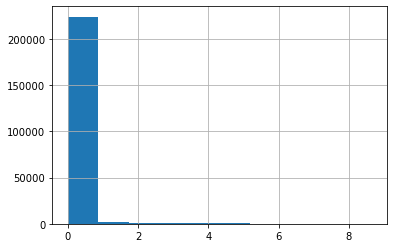

In [24]:
abc.hist()

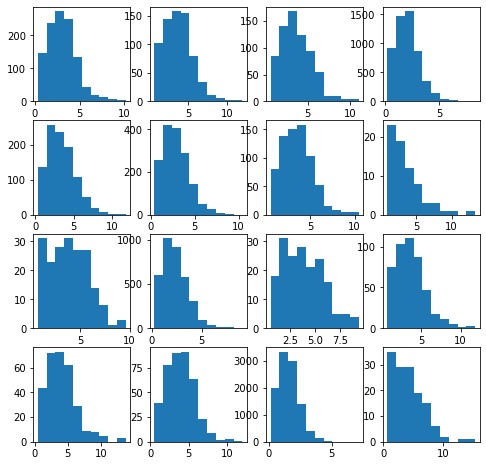

In [40]:
fig, ax = plt.subplots(4,4,figsize=(8,8))
for i in range(16):
    abc = multi_train_x[:,i].toarray().flatten()
    abc = list(filter(lambda x: x > 0, abc))
    j = i%4
    k = i//4
    ax[j][k].hist(abc)

In [41]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
i = 7
selector[i] = meta.loc[(meta.day == i)].range.values

In [43]:
X_copy = np.load('./binarized_pca/multi_pca_128.npy')

In [44]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
X_copy = multi_train_x[:,:40]
for i in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[i]]
    evaluate(i,'multi',save=False)

231/231 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 25.40999984741211
Correlation = 0.58309
PCA Correlation = 0.91061
model saved : ./multi_model_saves/model_7_0_0
231/231 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 24.690000534057617
Correlation = 0.59858
PCA Correlation = 0.91709
model saved : ./multi_model_saves/model_7_0_1
230/230 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 25.31999969482422
Correlation = 0.58046
PCA Correlation = 0.91073
model saved : ./multi_model_saves/model_7_0_2
Mean corr = 0.58738


In [45]:
X_copy

<105942x40 sparse matrix of type '<class 'numpy.float32'>'
	with 71268 stored elements in Compressed Sparse Row format>

In [57]:
abc = list(filter(lambda x: x>0.01, svd1.components_[0]))

(array([711., 497., 365., 224., 157.,  86.,  32.,  24.,  13.,   4.]),
 array([0.01000164, 0.0108853 , 0.01176895, 0.01265261, 0.01353627,
        0.01441993, 0.01530358, 0.01618724, 0.0170709 , 0.01795456,
        0.01883821]),
 <BarContainer object of 10 artists>)

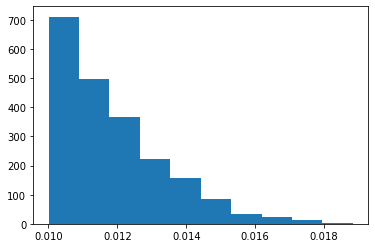

In [59]:
plt.hist(abc)

In [74]:
abc = set()
for i in range(40):
    abc = abc.union(set(list(np.where(svd1.components_[i] > 0.01)[0])))

In [75]:
len(abc)

12927

In [5]:
multi_train_x.shape

NameError: name 'multi_train_x' is not defined

In [81]:
X_copy = multi_train_x[:,list(abc)]

In [82]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
i = 2
selector[i] = meta.loc[(meta.day == i)].range.values

In [85]:
X_copy = X_copy.toarray()

In [86]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for i in selector.keys():
    targets = targets_copy[selector[i]]
    X = X_copy[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(i,'multi',save=False)

250/250 [==============================] - 1s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.600000381469727
Correlation = 0.68132
PCA Correlation = 0.97614
250/250 [==============================] - 1s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.789999961853027
Correlation = 0.67173
PCA Correlation = 0.97499
250/250 [==============================] - 1s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.6899995803833
Correlation = 0.67655
PCA Correlation = 0.97563
Mean corr = 0.67653


In [95]:
abc = set()
for i in range(40):
    abc = abc.union(set(list(np.where(svd1.components_[i] > 0.04)[0])))

In [96]:
len(abc)

96

In [101]:
X0 = multi_train_x[:,list(abc)].toarray()
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
X_copy = np.hstack([X_copy,X0])
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)

In [102]:
for i in selector.keys():
    targets = targets_copy[selector[i]]
    X = X_copy[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(i,'multi',save=False)

250/250 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.5
Correlation = 0.68712
PCA Correlation = 0.98449
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 5.050000190734863
Correlation = 0.67888
PCA Correlation = 0.98548
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 5.610000133514404
Correlation = 0.68231
PCA Correlation = 0.98399
Mean corr = 0.68277


Getting the components for X_copy

In [5]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]

In [4]:
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [38]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
donors = (32606,13176,31800)
for i in (2,3,4,7):
    for j in donors:
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [10]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for (i,j) in selector.keys():
    if i == 7:
        targets = targets_copy.copy()
        targets = targets[selector[(i,j)]]
        # Normalize the targets row-wise: This doesn't change the correlations,
        # and negative_correlation_loss depends on it
        targets -= targets.mean(axis=1).reshape(-1, 1)
        targets /= targets.std(axis=1).reshape(-1, 1)
        targets = np.array(targets)
        svd = TruncatedSVD(n_components = 512,random_state = 1)
        Y = svd.fit_transform(targets)[:,:64]
        X = multi_train_x[selector[(i,j)]]
        X = svd1.fit_transform(X)[:,:40]
        print(i)
        print(j)
        evaluate(i,'multi',save=False)

7
32606


2022-11-15 18:28:28.245571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 18:28:28.339970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-15 18:28:28.339999: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-15 18:28:28.340444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

73/73 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.199999809265137
Correlation = 0.62491
PCA Correlation = 0.96857
73/73 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 9.380000114440918
Correlation = 0.62413
PCA Correlation = 0.96798
73/73 [==============================] - 0s 1ms/step

 --------- FOLD 2 -----------
Mean squared error = 9.1899995803833
Correlation = 0.62379
PCA Correlation = 0.96853
Mean corr = 0.62428


KeyboardInterrupt: 

In [11]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    selector[i] = meta.loc[(meta.day == i)].range.values

In [12]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for i in selector.keys():
    if i == 7:
        targets = targets_copy.copy()
        targets = targets[selector[i]]
        # Normalize the targets row-wise: This doesn't change the correlations,
        # and negative_correlation_loss depends on it
        targets -= targets.mean(axis=1).reshape(-1, 1)
        targets /= targets.std(axis=1).reshape(-1, 1)
        targets = np.array(targets)
        svd = TruncatedSVD(n_components = 512,random_state = 1)
        Y = svd.fit_transform(targets)[:,:64]
        X = multi_train_x[selector[i]]
        X = svd1.fit_transform(X)[:,:40]
        print(i)
        evaluate(i,'multi',save=False)

7
231/231 [==============================] - 0s 1ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.130000114440918
Correlation = 0.61990
PCA Correlation = 0.96859
231/231 [==============================] - 0s 1ms/step

 --------- FOLD 1 -----------
Mean squared error = 7.699999809265137
Correlation = 0.63604
PCA Correlation = 0.97500
230/230 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.600000381469727
Correlation = 0.61843
PCA Correlation = 0.97059
Mean corr = 0.62479


not worth to split up the X PCA by day

In [7]:
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")
multi_test_x = scipy.sparse.load_npz("./sparse/test_multi_inputs_values.sparse.npz")

In [8]:
from scipy.sparse import vstack
svd1 = TruncatedSVD(n_components = 128)
both = svd1.fit(vstack([multi_train_x,multi_test_x]))
np.save("./multi_pca/inputs_both_128_svds.npy",svd1.components_)
np.save("./multi_pca/inputs_both_128_exp_var.npy",svd1.explained_variance_ratio_)

In [7]:
components = np.load("./multi_pca/inputs_both_128_svds.npy")
exp_var = np.load("./multi_pca/inputs_both_128_exp_var.npy")

In [8]:
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [9]:
components = components[:40]

In [10]:
comp_weighted = exp_var[:40]@np.abs(components)

In [11]:
abc = list(np.where(comp_weighted > 0.00003)[0])
print(len(abc))

17663


In [42]:
abc

[40332, 100203, 108472, 115462, 140191]

In [28]:
abc = set()
for i in range(40):
    abc = abc.union(set(list(np.where(exp_var[i]*np.abs(components[i]) > 0.000042)[0])))
print(len(abc))

1


In [12]:
X_copy = multi_train_x[:,abc]

In [13]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
i = 2
j = 32606
selector[i] = meta.loc[(meta.day == i)&(meta.donor==j)].range.values

In [ ]:
X_copy = X_copy.toarray()

In [ ]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for i in selector.keys():
    targets = targets_copy[selector[i]]
    X = X_copy[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    evaluate(i,'multi',save=False)

In [ ]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
targets = targets_copy[selector[i]]
X = X_copy[selector[i]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]

In [ ]:
X = X_copy[selector[i]]
evaluate(i,'multi',save=False)

In [11]:
X.shape

(23911, 1)

comp_weighted
position  id    gene    performance    pca
1         40332         0.67892        0.96413
2         115462        0.67891        0.96412
3         100203        0.67879        0.96393
4         140191        0.67862        0.96370
5         108472        0.67882        0.96399
Top 72    ()            0.68187        0.96825
Top 348   ()            0.68303        0.96987
Top 1318  ()            0.68381        0.97103
Top 4578  ()            0.68442        0.97182
PCA 40                  0.69091        0.98118

Text(0, 0.5, 'Correlation')

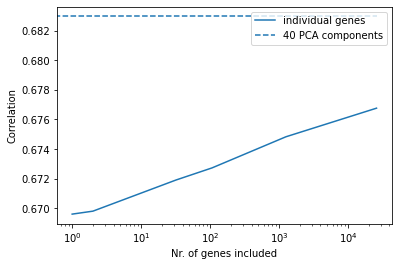

In [21]:
fig, ax = plt.subplots()
x = [26000,1262,107,32,2,1]
y = [0.67676,0.67483,0.67273,0.67191,0.66981,0.66961]
ax.plot(x,y,label = "individual genes")
ax.hlines(0.68295,xmin=0,xmax = 26000, label = '40 PCA components',linestyle='--')
ax.legend()
ax.set_xlabel('Nr. of genes included')
ax.set_xscale('log')
ax.set_ylabel('Correlation')
# ax2 = ax.twinx()
# ax2.plot([26000,1],[0.98490,0.96554],color='r')
# ax2.set_ylabel('PCA 64 Correlation')


In [3]:
with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_columns = data['columns']

In [18]:
abc

{100203}

In [8]:
cell_columns[108472]

'chr20:44543967-44544901'

In [28]:
pd.Series(X_copy.flatten()).value_counts()

0.000000    95401
2.529749        3
2.402490        3
2.298290        3
3.165558        2
            ...  
2.793299        1
2.691183        1
2.581706        1
2.565930        1
1.792285        1
Length: 10385, dtype: int64

In [29]:
len(X_copy)

105942

In [30]:
105942-95401

10541

so this amazing gene that does everything is zero 90% of the time.

Text(0, 0.5, 'count')

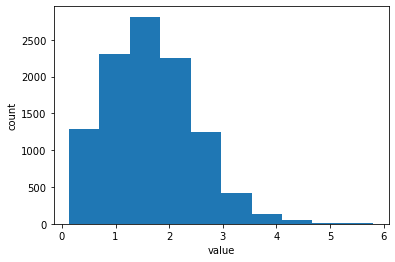

In [32]:
plt.hist(list(filter(lambda x: x> 0,X_copy.flatten())))
plt.xlabel('value')
plt.ylabel('count')

In [33]:
np.save('./sparse/miracle.npy',X_copy)

In [35]:
miracle = X_copy.copy()

In [37]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
X_copy = np.hstack([X_copy,miracle])
for i in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[i]]
    evaluate(i,'multi',save=False)

250/250 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 5.429999828338623
Correlation = 0.68724
PCA Correlation = 0.98468
250/250 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 4.96999979019165
Correlation = 0.67902
PCA Correlation = 0.98569
250/250 [==============================] - 0s 1ms/step

 --------- FOLD 2 -----------
Mean squared error = 5.550000190734863
Correlation = 0.68241
PCA Correlation = 0.98414
Mean corr = 0.68289


Before: Mean corr = 0.68295
So this gene doesn't add anything that wasn't already contained in PCA components.

In [8]:
exp_var.shape

(128,)

In [ ]:
components.shape

(128, 228942)

(5.74e-05, 0.00010592506332613993)

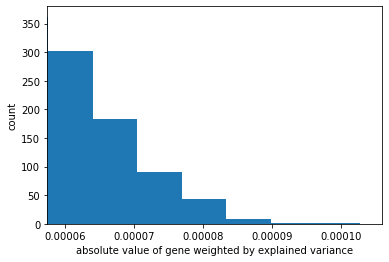

In [33]:
plt.hist(np.abs(components[:,list(abc)]).T@exp_var)
plt.xlabel('absolute value of gene weighted by explained variance')
plt.ylabel('count')
plt.xlim(left = 0.0000574)

In [39]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
i = 0
selector[i] = meta.loc[(meta.day == 2)&(meta.donor == 32606)].range.values

In [40]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for i in selector.keys():
    targets = targets_copy[selector[i]]
    X = X_copy[selector[i]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    models = evaluate(i,'multi',save=False)

2022-11-15 21:18:44.342809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 21:18:44.349971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-15 21:18:44.349994: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-15 21:18:44.350418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

76/76 [==============================] - 0s 4ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.819999694824219
Correlation = 0.68498
PCA Correlation = 0.97264
76/76 [==============================] - 0s 3ms/step

 --------- FOLD 1 -----------
Mean squared error = 10.109999656677246
Correlation = 0.68314
PCA Correlation = 0.97170
76/76 [==============================] - 0s 4ms/step

 --------- FOLD 2 -----------
Mean squared error = 10.069999694824219
Correlation = 0.68170
PCA Correlation = 0.97180
Mean corr = 0.68327


In [50]:
targets_copy = targets_copy.toarray()

In [52]:
selector_31800 = meta.loc[(meta.day == 2)&(meta.donor == 31800)].range.values

In [68]:
corr = 0
pred_raw = np.zeros((len(X_copy[selector_31800]),targets_copy.shape[1]))
for fold in range(3):
    model = models[fold]
    pred_raw += model.predict(X_copy[selector_31800])@svd.components_[:64]
    corr += correlation_score(targets_copy[selector_31800],pred_raw)/3
print(f'corr = {corr}')

222/222 [==============================] - 1s 3ms/step
corr = 0.6759688482609001


In [59]:
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy_PCA = inputs_both_128[:targets_copy.shape[0],:40]

In [63]:
corr = 0
pred_raw_PCA = np.zeros((len(X_copy_PCA[selector_31800]),targets_copy.shape[1]))
svds = np.load(f"./multi_model_saves/model_2_32606_svds.npy")
for fold in range(3):
    model = load_model(f"./multi_model_saves/model_2_32606_{fold}")
    pred_raw_PCA += model.predict(X_copy_PCA[selector_31800])@svds[:64]
    corr += correlation_score(targets_copy[selector_31800],pred_raw_PCA)/3
print(f'corr = {corr}')

222/222 [==============================] - 1s 2ms/step
corr = 0.6804574750609126


In [69]:
pred_raw_PCA -= pred_raw_PCA.mean(axis=1).reshape(-1, 1)
pred_raw_PCA /= pred_raw_PCA.std(axis=1).reshape(-1, 1)
pred_raw -= pred_raw.mean(axis=1).reshape(-1, 1)
pred_raw /= pred_raw.std(axis=1).reshape(-1, 1)
for i in (0,0.1,0.2,0.3,0.4,0.5):
    pred_raw_combined = i*pred_raw + (1-i)*pred_raw_PCA
    print(i)
    print(correlation_score(targets_copy[selector_31800],pred_raw_combined))

0
0.6805654133079669
0.1
0.6806809139881743
0.2
0.6806758518982824
0.3
0.6805492978288414
0.4
0.6803007023661078
0.5
0.6799299098249159
